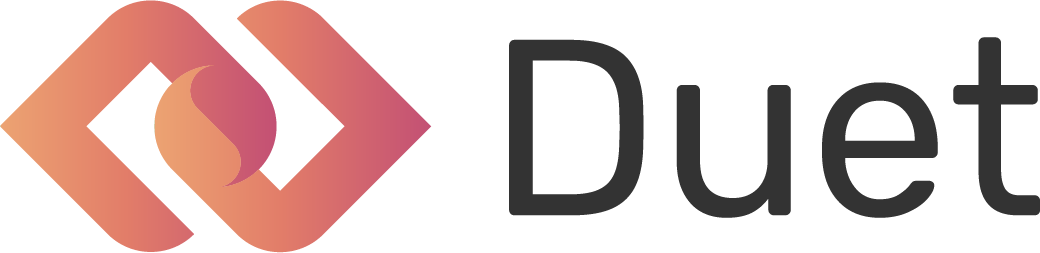

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-18-216-8-163.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > CONNECTED!


In [1]:
import syft as sy
duet = sy.join_duet(loopback=True)

In [2]:
import torch
from math import sqrt
import time

In [3]:
import os

config = {"epochs":1,
          "batch_size":1,
          "d_embed":100,
          "d_proj":300,
          "d_hidden":300,
          "n_layers":1,
          "log_every":50,
          "lr":.001,
          "dev_every":1000,
          "save_every":1000,
          "dp_ratio":0.2,
          "birnn":None,
          "lower":None,
          "projection":None,
          "fix_emb":None,
          "gpu":-1,
          "save_path":"results",
          "vector_vache":os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt'),
          "word_vectors":'glove.6B.100d',
          "resume_snapshow":""}

In [4]:
sentence_encoder_vocab_size = duet.store["sentence_encoder_vocab_size"]
label_encoder_vocab_size = duet.store["label_encoder_vocab_size"]
train = duet.store["train"]
dev = duet.store["dev"]
test = duet.store["test"]

In [5]:
remote_torch = duet.torch

In [22]:
class Bottle(sy.Module):
    def __init__(self, torch_ref):
        super(Bottle, self).__init__(torch_ref=torch_ref)
        
    def forward(self, input):
        if len(input.size()) <= 2:
            return super(Bottle, self).forward(input)
        size = input.size()[:2]
        out = super(Bottle, self).forward(input.view(size[0] * size[1], -1))
        return out.view(size[0], size[1], -1)


class MyLinear(sy.Module):
    def __init__(self, torch_ref, in_features, out_features):
        super().__init__(torch_ref = torch_ref)
        self.in_features = in_features
        self.out_features = out_features
        self.lin = self.torch_ref.nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.lin(x)
    
class Linear(Bottle, MyLinear):
    pass


class Encoder(sy.Module):

    def __init__(self, torch_ref, config):
        super(Encoder, self).__init__(torch_ref = torch_ref)
        self.config = config
        input_size = config["d_proj"] if config["projection"] else config["d_embed"]
        self.rnn = self.torch_ref.nn.LSTM(
            input_size=input_size,
            hidden_size=config["d_hidden"],
            num_layers=config["n_layers"],
            dropout=config["dp_ratio"],
            bidirectional=config["birnn"])

    def forward(self, inputs):
        batch_size = inputs.size()[1]
        state_shape = self.config.n_cells, batch_size, self.config["d_hidden"]
        h0 = c0 = inputs.detach().new_zeros(*state_shape)
        rnn_outputs = self.rnn(inputs, (h0, c0))
        outputs, (ht, ct) = rnn_outputs[0], rnn_outputs[1]
        return ht[-1] if not self.config["birnn"] else ht[-2:].transpose(0, 1).contiguous().view(
            batch_size, -1)


class SNLIClassifier(sy.Module):

    def __init__(self, torch_ref, config):
        super(SNLIClassifier, self).__init__(torch_ref = torch_ref)
        self.config = config
        self.embed = self.torch_ref.nn.Embedding(config["n_embed"], config["d_embed"])
        self.projection = self.torch_ref.nn.Linear(config["d_embed"], config["d_proj"])
        self.encoder = Encoder(torch, config)
        self.dropout = self.torch_ref.nn.Dropout(p=config["dp_ratio"])
        self.relu = self.torch_ref.nn.ReLU()
        seq_in_size = 2 * config["d_hidden"]
        if self.config["birnn"]:
            seq_in_size *= 2
        lin_config = [seq_in_size] * 2
        self.out = self.torch_ref.nn.Sequential(
            self.torch_ref.nn.Linear(*lin_config),
            self.relu, self.dropout,
            self.torch_ref.nn.Linear(*lin_config),
            self.relu,
            self.dropout,
            self.torch_ref.nn.Linear(*lin_config),
            self.relu, self.dropout,
            self.torch_ref.nn.Linear(seq_in_size, config["d_out"]))

    def forward(self, premise, hypothesis):
        prem_embed = self.embed(premise)
        hypo_embed = self.embed(hypothesis)
        if self.config["fix_emb"]:
            prem_embed = prem_embed.detach()
            hypo_embed = hypo_embed.detach()
        if self.config["projection"]:
            prem_embed = self.relu(self.projection(prem_embed))
            hypo_embed = self.relu(self.projection(hypo_embed))
        premise = self.encoder(prem_embed)
        hypothesis = self.encoder(hypo_embed)
        scores = self.out(torch.cat([premise, hypothesis], 1))
        return scores

In [23]:
config["n_embed"] = sentence_encoder_vocab_size.get(request_block=True, delete_obj=False)
config["d_out"] = label_encoder_vocab_size.get(request_block=True, delete_obj=False)
config["n_cells"] = config["n_layers"]
if config["birnn"]:
    config["n_cells"] *= 2

In [24]:
model = SNLIClassifier(torch, config)
remote_model = model.send(duet)

In [25]:
criterion = remote_torch.nn.CrossEntropyLoss()
opt = remote_torch.optim.Adam(remote_model.parameters(), lr=config["lr"])

iterations = 0
start = time.time()
best_dev_acc = -1
header = '  Time Epoch Iteration Progress    (%Epoch)   Loss   Dev/Loss     Accuracy  Dev/Accuracy'
dev_log_template = ' '.join(
    '{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.0f}%,{:>8.6f},{:8.6f},{:12.4f},{:12.4f}'
    .split(','))
log_template = ' '.join(
    '{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.0f}%,{:>8.6f},{},{:12.4f},{}'.split(','))

In [26]:
from syft.core.plan.plan_builder import make_plan, build_plan_inputs

dummy_dl = sy.lib.python.List([{'premise': torch.Tensor([ 5,  6,  7,  5,  8,  9, 10,  5, 11, 12, 13]),
 'hypothesis': torch.Tensor([ 5,  6, 67, 68, 69,  8, 70,  5, 71]),
 'label': torch.Tensor(1),
 'premise_transitions': ['shift',
  'shift',
  'shift',
  'shift']}])
'''
dummy_flag = sy.lib.python.Bool(True)

@make_plan
def collate_fn(batch=dummy_dl, train=dummy_flag):
    """ list of tensors to a batch tensors """
    premise_batch, _ = stack_and_pad_tensors([remote_torch.Tensor(row['premise']) for row in batch])
    hypothesis_batch, _ = stack_and_pad_tensors([row['hypothesis'] for row in batch])
    label_batch = torch.stack([row['label'] for row in batch])

    # PyTorch RNN requires batches to be transposed for speed and integration with CUDA
    transpose = (lambda b: b.t_().squeeze(0).contiguous())

    return (transpose(premise_batch), transpose(hypothesis_batch), transpose(label_batch))
'''

@make_plan
def collate_fn(batch=dummy_dl):
    return batch[0]  

In [27]:
for epoch in range(config["epochs"]):
    print(epoch)
    n_correct, n_total = 0, 0

    train_sampler = remote_torch.utils.data.sampler.SequentialSampler(train)
    train_batch_sampler = remote_torch.utils.data.BatchSampler(
        train_sampler, config["batch_size"], True)
    train_iterator = remote_torch.utils.data.DataLoader(
        train,
        batch_sampler=train_batch_sampler,
        collate_fn=collate_fn,
        pin_memory=False,
        num_workers=0)
    
    for batch_idx, data in enumerate(train_iterator):
        premise_batch, hypothesis_batch, label_batch = data[0], data[1], data[2]
        # switch model to training mode, clear gradient accumulators
        model.train()
        remote_torch.set_grad_enabled(True)
        opt.zero_grad()

        iterations += 1

        # forward pass
        answer = model(premise_batch, hypothesis_batch)

        # calculate accuracy of predictions in the current batch
        n_correct += (remote_torch.max(answer, 1)[1].view(label_batch.size()) == label_batch).sum()
        n_total += premise_batch.size()[1]
        train_acc = 100. * n_correct / n_total

        # calculate loss of the network output with respect to training labels
        loss = criterion(answer, label_batch)

        # backpropagate and update optimizer learning rate
        loss.backward()
        opt.step()

0


TypeError: embedding(): argument 'indices' (position 2) must be Tensor, not TensorPointer